# Galaxy Selection for Cross-Correlation with 2017 CLAMATO data

Select galaxies at 2.0<z<2.6 from the various spectroscopic catalogs in the COSMOS field. Mostly for cross-correlation analyses but also useful for other projects.

In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table

from fnmatch import fnmatch

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

# These are coordinates of the tomographic map
ra0 = 149.950000
dec0 = 2.150000
ra1 = 150.39359
dec1 =  2.5048765

# Redshift range to consider. 
# This is a bit broader than the redshift range used in the tomographic map since 
# we don't need such a high sightline density.
zmin = 2.0
zmax = 2.6
zmid = (zmin+zmax)/2.

# degrees per transverse Mpc/h
deg_per_hMpc = 1./ cosmo.h / cosmo.comoving_distance(zmid).value * 180./np.pi
print('Comoving distance to z={:f} (in Mpc): {:f}'.format(zmid, cosmo.comoving_distance(zmid)))

# Look for galaxies up to 15Mpc/h transverse from the central map region
d_ra  = 15. * deg_per_hMpc
d_dec = 15. * deg_per_hMpc


Comoving distance to z=2.300000 (in Mpc): 5534.409721 Mpc


### Get MOSDEF galaxies. 
These are our top priority redshifts.

ColDefs(
    name = 'FIELD'; format = '7A'
    name = 'ID_V2'; format = 'J'
    name = 'ID_V4'; format = 'J'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'Z_MOSFIRE'; format = 'E'
    name = 'MASKNAME'; format = '6A'
    name = 'TARGET'; format = 'J'
)
There are 121 coeval galaxies from MOSDEF


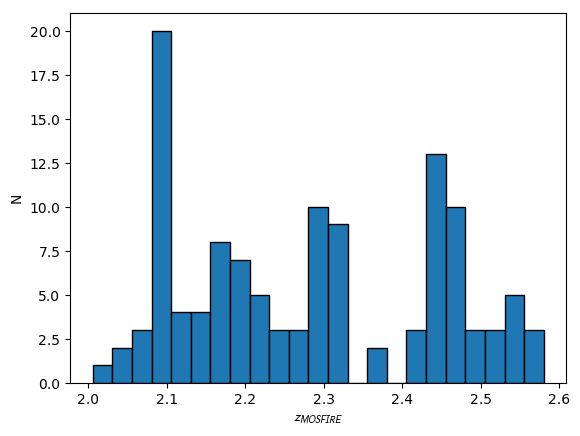

In [2]:
catdir = '/Users/kheegan/lya/3d_recon/ts/ts_cats/'
mosdef2016_fil = catdir+'mosdef_zcat.16aug2016.fits'
#mosdef2015_fil = catdir+'mosdef_zcat.1oct2015.fits'

catmd = fits.open(mosdef2016_fil)

print(catmd[1].columns)

#catmd[1]

catmddata = catmd[1].data

# filter for COSMOS galaxies in the right redshift 
getcosmos = catmddata['FIELD'] == 'COSMOS' 
lowzcut = catmddata['Z_MOSFIRE'] >= zmin
hizcut  = catmddata['Z_MOSFIRE'] < zmax
racut1 = catmddata['RA']> (ra0 - d_ra)
racut2 = catmddata['RA']< (ra1 + d_ra)
deccut1 = catmddata['DEC']> (dec0 - d_ra) 
deccut2 = catmddata['DEC']< (dec1 + d_ra)

allcuts = lowzcut & getcosmos & hizcut & racut1 & racut2 & deccut1 & deccut2

catmddata = catmddata[allcuts]

# Remove objects with duplicate observations from different MOSDEF masks
tmp, u_ind = np.unique(catmddata['ID_V4'], return_index=True)
catmddata = catmddata[u_ind]

ra_md  = catmddata['RA']
dec_md = catmddata['DEC']
MosdefCoord = SkyCoord(ra=ra_md*u.degree, dec=dec_md*u.degree)

#coord= plt.scatter(ra_md, dec_md, marker='o')
print('There are '+str(len(catmddata))+' coeval galaxies from MOSDEF')

fig, ax = plt.subplots()
binwidth=0.025
ax.hist(catmddata['Z_MOSFIRE'],bins=np.arange(min(catmddata['Z_MOSFIRE']),
                                               max(catmddata['Z_MOSFIRE']) + binwidth, binwidth),
       ec='black')
ax.set_xlabel(r'$z_{MOSFIRE}$')
ax.set_ylabel('N')
plt.show()

# Initialize catalog and SkyCoord for all galaxies
ra_all  = ra_md
dec_all = dec_md
z_all   = catmddata['Z_MOSFIRE']
id_all = catmddata['ID_V4']
source_all = np.asarray(['MOSDEF']*len(catmddata))
SkyCoord_all = MosdefCoord

# This is the same, but keeps track of a list which does not remove overlaps
ra_ol  = ra_md
dec_ol = dec_md
z_ol   = catmddata['Z_MOSFIRE']
id_ol = catmddata['ID_V4']
source_ol = np.asarray(['MOSDEF']*len(catmddata))
SkyCoord_ol = MosdefCoord

###  Grab ZFIRE galaxies

In [3]:
zfire_specz_fil = ('/Users/kheegan/scratch/cosmos/spec/zfire_dr1_cats/'
                   'master_table/ZFIRE_COSMOS_master_table_DR1.1.dat')

zfire = ascii.read(zfire_specz_fil, format='fast_commented_header', header_start=-1)

print('Read in {:d} ZFIRE galaxies from catalog'.format(len(zfire)))

# Remove any object where RA, Dec or zspec is '--'
cutdodgy = np.all(np.column_stack([(zfire['RA'].data != '--'),
                                  (zfire['DEC'].data != '--'),
                                  (zfire['zspec'].data != '--')]),axis=1)

zfire = zfire[cutdodgy]
print('{:d} objects left after ensuring finite RA, Dec, zspec'.format(len(zfire)))

zspec_zf = zfire['zspec'].data

zspec_zf = zspec_zf.astype('float')
ra_zf   = zfire['RA'].data
ra_zf   = ra_zf.astype('float')
dec_zf  = zfire['DEC'].data
dec_zf  = dec_zf.astype('float')
conf_zf = zfire['conf'].data
conf_zf = conf_zf.astype('int')

# Evaluate approximate footprint of this survey. We take 1st and 99th percentiles in order 
# to eliminate outliers
ra_low = np.percentile(ra_zf, 1. )
ra_hi  = np.percentile(ra_zf, 99.)
dec_low = np.percentile(dec_zf, 1.)
dec_hi = np.percentile(dec_zf, 99.)
print('Survey Boundaries:')
print('Min/Max RA: {:f}, {:f}'.format(ra_low, ra_hi))
print('Min/Max Dec: {:f}, {:f}'.format(dec_low, dec_hi))

id_zf = zfire['Nameobj'].data
id_zf = id_zf.astype('int')

#redshift, quality and coordinate cuts
zcut = np.all(np.column_stack([(zspec_zf >= zmin) ,
                            (zspec_zf < zmax),
                            (ra_zf >= ra0-d_ra),
                            (ra_zf <= ra1+d_ra),
                              (dec_zf >= dec0-d_dec),
                              (dec_zf <= dec1+d_dec),
                              (conf_zf >= 3)]), axis=1)

ra_zf = ra_zf[zcut]
dec_zf = dec_zf[zcut]
conf_zf = conf_zf[zcut]
zspec_zf = zspec_zf[zcut]
id_zf  = id_zf[zcut]

#fig, ax = plt.subplots()
#binwidth=0.025
#plt.hist(zspec_zf, bins=np.arange(min(zspec_zf), max(zspec_zf) + binwidth, binwidth))
#plt.show()

print('{:d} objects left after coordinate and redshift cuts'.format(len(zspec_zf)))

# Match coordinates with existing sample, and throw away any that match
zfCoord = SkyCoord(ra=ra_zf*u.degree,dec=dec_zf*u.degree)

idv, d2d , d3d = zfCoord.match_to_catalog_sky(SkyCoord_all)
idall, d2d_all, d3d_all = SkyCoord_all.match_to_catalog_sky(zfCoord)

closematch_zf = d2d < (0.5*u.arcsec)
notmatch_zf = np.invert(closematch_zf)

# This is the same match, but relative to the full catalog
closematch_all = d2d_all < (0.5*u.arcsec)

source_matched = source_all[closematch_all]

for i in np.unique(source_matched):
    uniqsource = i
    nsource = sum(1 for j in source_matched if j == uniqsource)
    print('{0:d} ZFIRE galaxies are also measured by {1:s}'.format(nsource, uniqsource))
    
print('We have {:} unique galaxies contributed by ZFIRE'.format(sum(1 for i in notmatch_zf if i)))

# Append current catalog to 'all' catalog
ra_all = np.concatenate((ra_all, ra_zf[notmatch_zf]))
dec_all = np.concatenate((dec_all, dec_zf[notmatch_zf]))
z_all  = np.concatenate((z_all, zspec_zf[notmatch_zf]))
id_all = np.concatenate((id_all, id_zf[notmatch_zf]))
source_tmp = np.asarray(['ZFIRE']*len(zspec_zf[notmatch_zf]))
source_all = np.concatenate((source_all,source_tmp ))

# Append current catalog to 'overlap' catalog
ra_ol = np.concatenate((ra_ol, ra_zf))
dec_ol = np.concatenate((dec_ol, dec_zf))
z_ol  = np.concatenate((z_ol, zspec_zf))
id_ol = np.concatenate((id_ol, id_zf))
source_tmp = np.asarray(['ZFIRE']*len(zspec_zf))
source_ol = np.concatenate((source_ol, source_tmp))

Read in 233 ZFIRE galaxies from catalog
157 objects left after ensuring finite RA, Dec, zspec
Survey Boundaries:
Min/Max RA: 150.045719, 150.226099
Min/Max Dec: 2.192476, 2.323064
136 objects left after coordinate and redshift cuts
13 ZFIRE galaxies are also measured by MOSDEF
We have 123 unique galaxies contributed by ZFIRE


### Add CLAMATO galaxies

165 galaxies after redshift and quality cuts
12 CLAMATO galaxies are also measured by MOSDEF
4 CLAMATO galaxies are also measured by ZFIRE
We have 149 unique galaxies contributed by CLAMATO


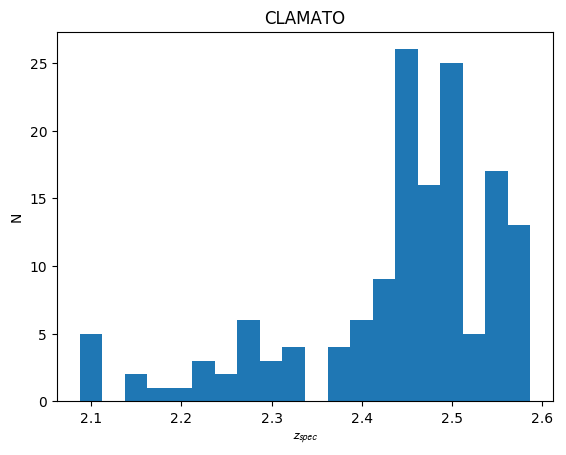

In [4]:
clamato_specz_fil = '/Users/kheegan/lya/3d_recon/data/cl2017_redux/cl2017_valueadded_20170426_widez.txt'

clamato = ascii.read(clamato_specz_fil,format='fast_commented_header',header_start=-1)

#Make redshift and quality cuts
zcut = np.all(np.column_stack([(clamato['zspec'] >= zmin) ,
                            (clamato['zspec'] < zmax),
                            (clamato['Conf'] >=3),
                              (clamato['Conf'] <10)]),axis=1)              
              
clamato = clamato[zcut]
print('%i galaxies after redshift and quality cuts' % len(clamato))

# Match coordinates with main sample, and throw away any that match
ClamatoCoord = SkyCoord(ra=clamato['RA']*u.degree,dec=clamato['Dec']*u.degree)

SkyCoord_all = SkyCoord(ra = np.asarray(ra_all)*u.degree, 
                        dec=np.asarray(dec_all)*u.degree)

idv, d2d , d3d = ClamatoCoord.match_to_catalog_sky(SkyCoord_all)
idall, d2d_all, d3d_all = SkyCoord_all.match_to_catalog_sky(ClamatoCoord)

closematch_tmp = d2d < (0.5*u.arcsec)
notmatch_tmp = np.invert(closematch_tmp)

# This is the same match, but relative to the full catalog
closematch_all = d2d_all < (0.5*u.arcsec)

source_matched = source_all[closematch_all]

for i in np.unique(source_matched):
    uniqsource = i
    nsource = sum(1 for j in source_matched if j == uniqsource)
    print('{0:d} CLAMATO galaxies are also measured by {1:s}'.format(nsource, uniqsource))
    
print('We have {:} unique galaxies contributed by CLAMATO'.format(sum(1 for i in notmatch_tmp if i)))

# Append current catalog to 'overlap' catalog
ra_ol = np.concatenate((ra_ol, clamato['RA']))
dec_ol = np.concatenate((dec_ol, clamato['Dec']))
z_ol  = np.concatenate((z_ol, clamato['zspec']))
id_ol = np.concatenate((id_ol, clamato['ObjID']))
source_tmp = np.asarray(['CLAMATO']*len(clamato))
source_ol = np.concatenate((source_ol, source_tmp ))

clamato = clamato[notmatch_tmp]

# Append current catalog to 'all' catalog
ra_all = np.concatenate((ra_all, clamato['RA']))
dec_all = np.concatenate((dec_all, clamato['Dec']))
z_all  = np.concatenate((z_all, clamato['zspec']))
id_all = np.concatenate((id_all, clamato['ObjID']))
source_tmp = np.asarray(['CLAMATO']*len(clamato))
source_all = np.concatenate((source_all, source_tmp ))

fig, ax = plt.subplots()
binwidth=0.025
ax.hist(clamato['zspec'],bins=np.arange(min(clamato['zspec']),
                                               max(clamato['zspec']) + binwidth, binwidth))
ax.set_xlabel(r'$z_{spec}$')
ax.set_ylabel('N')
ax.set_title('CLAMATO')
plt.show()

### Grab VUDS galaxies...

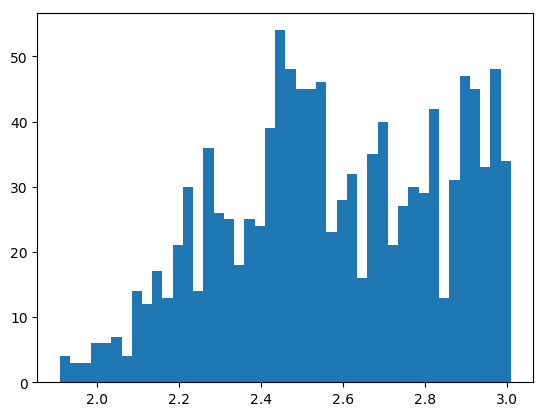

Survey Boundaries:
Min/Max RA:149.634085, 150.403611
Min/Max Dec:1.763045, 2.656499
437 galaxies after redshift, quality and positional cuts


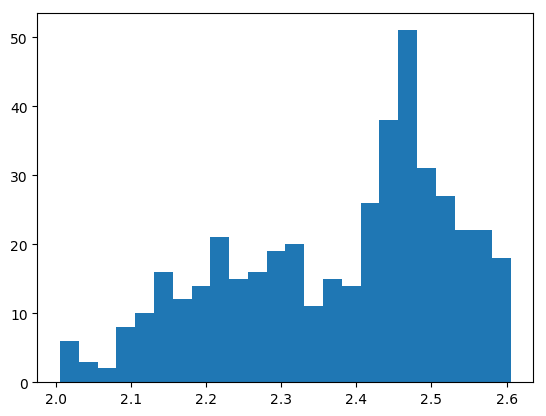

17 VUDS galaxies are also measured by CLAMATO
7 VUDS galaxies are also measured by MOSDEF
2 VUDS galaxies are also measured by ZFIRE
We have 411 unique galaxies contributed by VUDS


In [5]:
vuds_specz_fil = '/Users/kheegan/lya/3d_recon/ts/ts_cats/cesam_vuds_spectra_cosmos_catalog_1489008861.txt'

vuds = ascii.read(vuds_specz_fil,format='fast_commented_header',header_start=-1)

#print(np.sum(flag_z_vuds == 24))

fig, ax = plt.subplots()
zspec = vuds['z_spec']
binwidth=0.025
plt.hist(zspec, bins=np.arange(min(zspec), max(zspec) + binwidth, binwidth))
plt.show()

# Evaluate approximate footprint of this survey. We take 1st and 99th percentiles in order 
# to eliminate outliers
ra_low = np.percentile(vuds['alpha'], 0.5 )
ra_hi  = np.percentile(vuds['alpha'], 99.5)
dec_low = np.percentile(vuds['delta'], 0.5)
dec_hi = np.percentile(vuds['delta'], 99.5)

print('Survey Boundaries:')
print('Min/Max RA:{:f}, {:f}'.format(ra_low, ra_hi))
print('Min/Max Dec:{:f}, {:f}'.format(dec_low, dec_hi))

#redshift, quality and coordinate cuts
zcut = np.all(np.column_stack([(vuds['z_spec'] >= zmin) ,
                            (vuds['z_spec'] < zmax),
                            (vuds['alpha'] >= ra0-d_ra),
                            (vuds['alpha'] <= ra1+d_ra),
                              (vuds['delta'] >= dec0-d_dec),
                              (vuds['delta'] <= dec1+d_dec)]), axis=1)
                             #(vuds['zflags'] >=3),
                             #(vuds['zflags'] < 9)]),axis=1) 


vuds = vuds[zcut]
print('%i galaxies after redshift, quality and positional cuts' % len(vuds))

fig, ax = plt.subplots()
zspec = vuds['z_spec']
binwidth=0.025
plt.hist(zspec, bins=np.arange(min(zspec), max(zspec) + binwidth, binwidth))
plt.show()

# Match coordinates with main sample, and throw away any that match
vudsCoord = SkyCoord(ra=vuds['alpha']*u.degree,dec=vuds['delta']*u.degree)

SkyCoord_all = SkyCoord(ra = np.asarray(ra_all)*u.degree, dec=np.asarray(dec_all)*u.degree)

idv, d2d , d3d = vudsCoord.match_to_catalog_sky(SkyCoord_all)
idall, d2d_all, d3d_all = SkyCoord_all.match_to_catalog_sky(vudsCoord)

closematch_tmp = d2d < (0.5*u.arcsec)
notmatch_tmp = np.invert(closematch_tmp)

# This is the same match, but relative to the full catalog
closematch_all = d2d_all < (0.5*u.arcsec)

source_matched = source_all[closematch_all]

for i in np.unique(source_matched):
    uniqsource = i
    nsource = sum(1 for j in source_matched if j == uniqsource)
    print('{0:d} VUDS galaxies are also measured by {1:s}'.format(nsource, uniqsource))
    
print('We have {:} unique galaxies contributed by VUDS'.format(sum(1 for i in notmatch_tmp if i)))

# Append current catalog to 'overlap' catalog
ra_ol = np.concatenate((ra_ol, vuds['alpha']))
dec_ol = np.concatenate((dec_ol, vuds['delta']))
z_ol  = np.concatenate((z_ol, vuds['z_spec']))
id_ol = np.concatenate((id_ol, vuds['ident']))
source_tmp = np.asarray(['VUDS']*len(vuds))
source_ol = np.concatenate((source_ol, source_tmp ))

vuds = vuds[notmatch_tmp]

# Append current catalog to 'all' catalog
ra_all = np.concatenate((ra_all, vuds['alpha']))
dec_all = np.concatenate((dec_all, vuds['delta']))
z_all  = np.concatenate((z_all, vuds['z_spec']))
id_all = np.concatenate((id_all, vuds['ident']))
source_tmp = np.asarray(['VUDS']*len(vuds))
source_all = np.concatenate((source_all, source_tmp ))


### Now grab zCOSMOS-Deep galaxies...

[('Instr', '<U10'), ('ra', '<f8'), ('dec', '<f8'), ('ORI_ID', '<U25'), ('z_spec', '<f8'), ('Q_f', '<f8'), ('OPT_ID', '<i8'), ('ra_opt', '<f8'), ('dec_opt', '<f8'), ('Separation', '<f8'), ('group_id', '<i8'), ('group_size', '<i8'), ('Contact', '<U58')]
Survey Boundaries:
Min/Max RA: 149.468949, 150.761439
Min/Max Dec: 1.580586, 2.849602
2626 galaxies after redshift and positional cuts
512 galaxies within zCOSMOS-Deep after quality cuts
40 zCOSMOS galaxies are also measured by CLAMATO
10 zCOSMOS galaxies are also measured by MOSDEF
8 zCOSMOS galaxies are also measured by VUDS
5 zCOSMOS galaxies are also measured by ZFIRE
We have 449 unique galaxies contributed by zCOSMOS


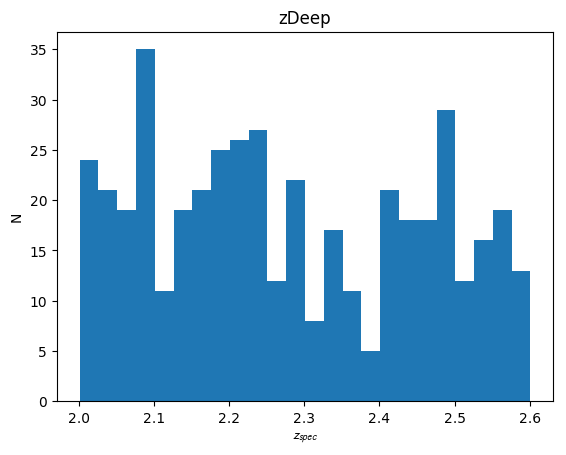

In [6]:
cosmos_specz_fil = '/Users/kheegan/scratch/cosmos/spec/'+\
'OBSERVED_TARGETS_15April2015_withHeader.dat'

cosmos = ascii.read(cosmos_specz_fil,format='fast_commented_header',header_start=-1)

print(cosmos.dtype)
#(set(cosmos['Instr']))

# Evaluate approximate footprint of this survey. We take 1st and 99th percentiles in order 
# to eliminate outliers
ra_low = np.percentile(cosmos['ra'], 0.5 )
ra_hi  = np.percentile(cosmos['ra'], 99.5)
dec_low = np.percentile(cosmos['dec'], 0.5)
dec_hi = np.percentile(cosmos['dec'], 99.5)
print('Survey Boundaries:')
print('Min/Max RA: {:f}, {:f}'.format(ra_low, ra_hi))
print('Min/Max Dec: {:f}, {:f}'.format(dec_low, dec_hi))

# make redshift and coordinate cuts
zcut = np.all(np.column_stack([(cosmos['z_spec'] >= zmin) ,
                            (cosmos['z_spec'] < zmax),
                            (cosmos['ra'] >= ra0-d_ra),
                            (cosmos['ra'] <= ra1+d_ra),
                              (cosmos['dec'] >= dec0-d_dec),
                              (cosmos['dec'] <= dec1+d_dec)]),axis=1)              
              
cosmos = cosmos[zcut]
print('%i galaxies after redshift and positional cuts' % len(cosmos))
#print(np.shape(cosmos))
# print(cosmos.meta) # These are the comments

#fig, ax = plt.subplots()
zspec = cosmos['z_spec']
binwidth=0.025
#plt.hist(zspec,bins=np.arange(min(zspec), max(zspec) + binwidth, binwidth))
#plt.show()

#[fnmatch(instr,'MOS*') for instr in cosmos['Instr']]

# get high-confidence (>3) redshifts from zCOSMOSDeep for galaxies only
confcut = np.all(np.column_stack(( (cosmos['Instr'] == 'zDEEP'),
                                   (cosmos['Q_f'] >= 3.),
                                   (cosmos['Q_f'] < 10.) )), axis=1)

cosmos = cosmos[confcut]
print('%i galaxies within zCOSMOS-Deep after quality cuts' % len(cosmos))

# Match coordinates with main sample, and throw away any that match
zDeepCoord = SkyCoord(ra=cosmos['ra']*u.degree,dec=cosmos['dec']*u.degree)

SkyCoord_all = SkyCoord(ra = np.asarray(ra_all)*u.degree, 
                        dec=np.asarray(dec_all)*u.degree)

idv, d2d , d3d = zDeepCoord.match_to_catalog_sky(SkyCoord_all)
idall, d2d_all, d3d_all = SkyCoord_all.match_to_catalog_sky(zDeepCoord)

closematch_tmp = d2d < (0.5*u.arcsec)
notmatch_tmp = np.invert(closematch_tmp)

# This is the same match, but relative to the full catalog
closematch_all = d2d_all < (0.5*u.arcsec)

source_matched = source_all[closematch_all]

for i in np.unique(source_matched):
    uniqsource = i
    nsource = sum(1 for j in source_matched if j == uniqsource)
    print('{0:d} zCOSMOS galaxies are also measured by {1:s}'.format(nsource, uniqsource))
    
print('We have {:} unique galaxies contributed by zCOSMOS'.format(sum(1 for i in notmatch_tmp if i)))

# Append current catalog to 'overlap' catalog
ra_ol = np.concatenate((ra_ol, cosmos['ra']))
dec_ol = np.concatenate((dec_ol, cosmos['dec']))
z_ol  = np.concatenate((z_ol, cosmos['z_spec']))
id_ol = np.concatenate((id_ol, cosmos['OPT_ID']))
source_tmp = np.asarray(['zDeep']*len(cosmos))
source_ol = np.concatenate((source_ol, source_tmp ))

cosmos = cosmos[notmatch_tmp]

# Append current catalog to 'all' catalog
ra_all = np.concatenate((ra_all, cosmos['ra']))
dec_all = np.concatenate((dec_all, cosmos['dec']))
z_all  = np.concatenate((z_all, cosmos['z_spec']))
id_all = np.concatenate((id_all, cosmos['OPT_ID']))
source_tmp = np.asarray(['zDeep']*len(cosmos))
source_all = np.concatenate((source_all, source_tmp ))

fig, ax = plt.subplots()
binwidth=0.025
ax.hist(cosmos['z_spec'],bins=np.arange(min(cosmos['z_spec']),
                                               max(cosmos['z_spec']) + binwidth, binwidth))
ax.set_xlabel(r'$z_{spec}$')
ax.set_ylabel('N')
ax.set_title('zDeep')
plt.show()



### Now ingest 3D-HST redshifts. 

Need to read in grism-z AND photometric redshifts separately and match them. We demand that FLAG1 and FLAG2 are both 0, which means that two people have signed off on each spectrum.


325 3D-HST galaxies pass basic cuts
15 3DHST galaxies are also measured by CLAMATO
55 3DHST galaxies are also measured by MOSDEF
9 3DHST galaxies are also measured by VUDS
49 3DHST galaxies are also measured by ZFIRE
13 3DHST galaxies are also measured by zDeep
We have 183 unique galaxies contributed by 3DHST


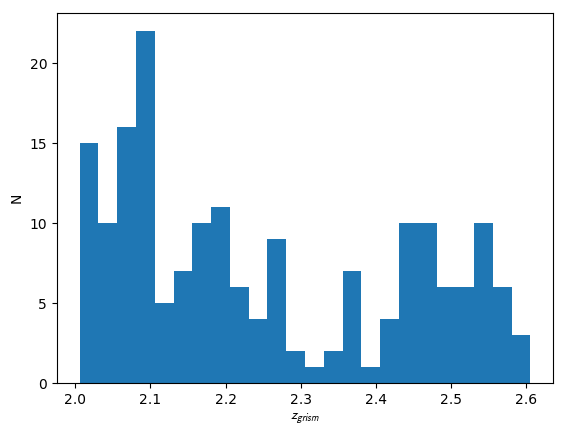

In [7]:
grismdir = '/Users/kheegan/scratch/cosmos/spec/cosmos_3dhst_v4.1.5_catalogs/'
grismfil = grismdir+'cosmos_3dhst.v4.1.5.zfit.linematched.fits'

phot3d_dir = '/Users/kheegan/scratch/cosmos/phot/cosmos_3dhst.v4.1.cats/Catalog/'
phot3d_fil = phot3d_dir+'cosmos_3dhst.v4.1.cat.FITS'

grism3d_tmp = fits.open(grismfil)
phot3d_tmp = fits.open(phot3d_fil)

#print(len(grism3d_tmp[1].data), len(phot3d[1].data))
#print(grism3d_tmp[1].columns)

grism3d = grism3d_tmp[1].data
phot3d  = phot3d_tmp[1].data

# Make cuts to grism-z's: redshift positions, and confidence... 
cut3dhst = np.all(np.column_stack([(grism3d['z_max_grism'] >= zmin),
                                  (grism3d['z_max_grism']<=zmax),
                                   (grism3d['flag1']==0),
                                   (grism3d['flag2']==0),
                                   (phot3d['ra'] >= ra0 - d_ra),
                                   (phot3d['ra'] <= ra1 + d_ra),
                                   (phot3d['dec'] >= dec0 - d_dec),
                                   (phot3d['dec'] <= dec1 + d_dec)
                                  ]) , axis=1)

grism3d = grism3d[cut3dhst]
phot3d  = phot3d[cut3dhst]
print('%i 3D-HST galaxies pass basic cuts' % len(grism3d))

# MAtch coordinates with MOSDEF sample
grismCoord = SkyCoord(ra=phot3d['ra']*u.degree, dec=phot3d['dec']*u.degree)

SkyCoord_all = SkyCoord(ra = np.asarray(ra_all)*u.degree, 
                        dec=np.asarray(dec_all)*u.degree)

idv, d2d , d3d = grismCoord.match_to_catalog_sky(SkyCoord_all)
idall, d2d_all, d3d_all = SkyCoord_all.match_to_catalog_sky(grismCoord)

closematch_tmp = d2d < (0.5*u.arcsec)
notmatch_tmp = np.invert(closematch_tmp)

# This is the same match, but relative to the full catalog
closematch_all = d2d_all < (0.5*u.arcsec)


#print(len(SkyCoord_all))
#print(len(source_all))
#print(len(closematch_all))

source_matched = source_all[closematch_all]

for i in np.unique(source_matched):
    uniqsource = i
    nsource = sum(1 for j in source_matched if j == uniqsource)
    print('{0:d} 3DHST galaxies are also measured by {1:s}'.format(nsource, uniqsource))
    
print('We have {:} unique galaxies contributed by 3DHST'.format(sum(1 for i in notmatch_tmp if i)))

# Append current catalog to 'overlap' catalog
ra_ol = np.concatenate((ra_ol, phot3d['ra']))
dec_ol = np.concatenate((dec_ol, phot3d['dec']))
z_ol  = np.concatenate((z_ol, grism3d['z_max_grism']))
id_ol = np.concatenate((id_ol, grism3d['phot_id']))
source_tmp = np.asarray(['3DHST']*len(grism3d))
source_ol = np.concatenate((source_ol, source_tmp ))

grism3d = grism3d[notmatch_tmp]
phot3d  = phot3d[notmatch_tmp]

# Append current catalog to 'all' catalog
ra_all = np.concatenate((ra_all, phot3d['ra']))
dec_all = np.concatenate((dec_all, phot3d['dec']))
z_all  = np.concatenate((z_all, grism3d['z_max_grism']))
id_all = np.concatenate((id_all, grism3d['phot_id']))
source_tmp = np.asarray(['3DHST']*len(grism3d))
source_all = np.concatenate((source_all, source_tmp ))

fig, ax = plt.subplots()
binwidth=0.025
ax.hist(grism3d['z_max_grism'],bins=np.arange(min(grism3d['z_max_grism']),
                                               max(grism3d['z_max_grism']) + binwidth, binwidth))
ax.set_xlabel(r'$z_{grism}$')
ax.set_ylabel('N')
plt.show()

Plot positions of the objects in comparison with CLAMATO tomographic map boundaries

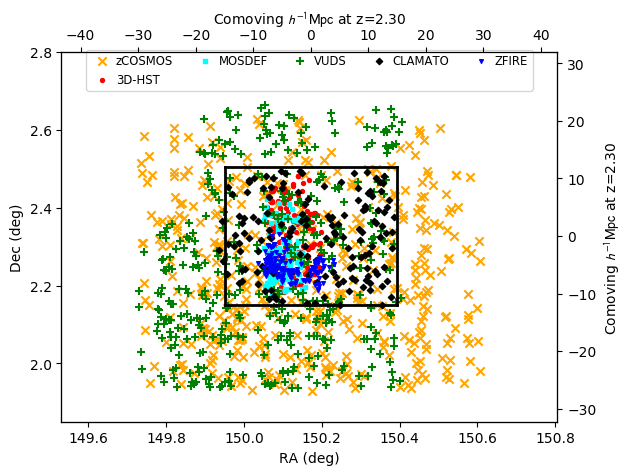

In [8]:
#Plot positions of all objects in comparison with CLAMATO map boundary
#Show 

fig, ax1 = plt.subplots()

ax1.get_xaxis().get_major_formatter().set_useOffset(False)

#Set aspect ratio 
ax1.set_aspect('equal','datalim')

pl1 = ax1.scatter(cosmos['ra'], cosmos['dec'], marker='x',label='zCOSMOS',color='orange')
pl2 = ax1.scatter(phot3d['ra'], phot3d['dec'], marker='o',label='3D-HST',color='r',s=8)
pl3 = ax1.scatter(ra_md, dec_md, marker='s',color='aqua', label='MOSDEF',s=8)
pl4 = ax1.scatter(vuds['alpha'], vuds['delta'], marker='+', label='VUDS', color='g')
pl5 = ax1.scatter(clamato['RA'], clamato['Dec'], marker='D', label='CLAMATO', color='k',s=10)
pl6 = ax1.scatter(ra_zf, dec_zf, marker='v', label='ZFIRE', color='b',s=7)
ax1.plot([ra0,ra1],[dec0,dec0], color='k',linestyle='-', linewidth=2)
ax1.plot([ra1,ra1],[dec0,dec1], color='k',linestyle='-', linewidth=2)
ax1.plot([ra1,ra0],[dec1,dec1], color='k',linestyle='-', linewidth=2)
ax1.plot([ra0,ra0],[dec1,dec0], color='k',linestyle='-', linewidth=2)

plt.legend(bbox_to_anchor=(0.05, 0.9, 0.9, 0.102), loc=10,
           ncol=5, mode="expand", borderaxespad=0.,scatterpoints=1,
           fontsize='small', handletextpad=0.15)
#plt.legend(loc='upper right',scatterpoints=1)

ax1.set_ylabel('Dec (deg)')
ax1.set_xlabel('RA (deg)')

# Custom y-axis limits to give space for legend
ax1.set_ylim(1.85,2.8)

# Need to this to set the axis limits
plt.draw()

# Define zero-point of transverse comoving distance scale as center of tomographic map.
ramid = (ra0+ra1)/2.
decmid = (dec0+dec1)/2.


ax2 = ax1.twinx()
dec_plran = ax1.get_ylim()
ycom_min= (dec_plran[0] - decmid)/deg_per_hMpc
ycom_max= (dec_plran[1] - decmid)/deg_per_hMpc
ax2.set_ylabel('Comoving '+r'$h^{-1}\mathrm{Mpc}$'+' at z=2.30' )
ax2.set_ylim([ycom_min,ycom_max])

ax3 = ax1.twiny()
ra_plran = ax1.get_xlim()
xcom_min = (ra_plran[0] - ramid)/deg_per_hMpc
xcom_max = (ra_plran[1] - ramid)/deg_per_hMpc
ax3.set_xlabel('Comoving '+r'$h^{-1}\mathrm{Mpc}$'+' at z=2.30' )
ax3.set_xlim([xcom_min,xcom_max])

#ax3.grid(color='y', linestyle='-', linewidth=1, which='both')

plt.show()




Same as before, but with the 'all' catalog as sanity check

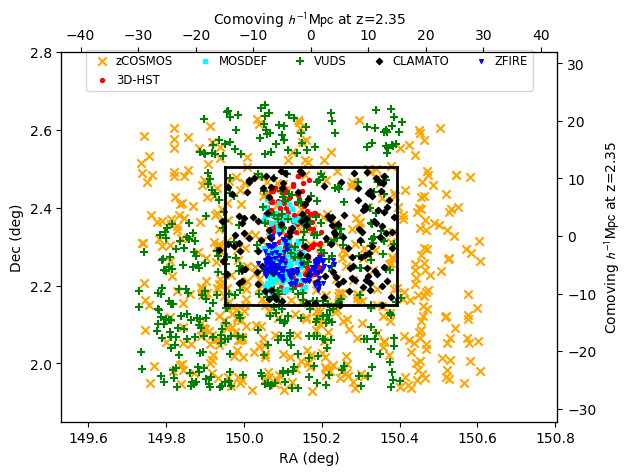

In [9]:
fig, ax1 = plt.subplots()

ax1.get_xaxis().get_major_formatter().set_useOffset(False)

#Set aspect ratio 
ax1.set_aspect('equal','datalim')

getzdeep = source_all == 'zDeep'
get3d   = source_all =='3DHST'
getmd   = source_all =='MOSDEF'
getvuds = source_all =='VUDS'
getzfire = source_all=='ZFIRE'
getclamato = source_all =='CLAMATO'

pl1 = ax1.scatter(ra_all[getzdeep], dec_all[getzdeep], marker='x',label='zCOSMOS',color='orange')
pl2 = ax1.scatter(ra_all[get3d], dec_all[get3d], marker='o',label='3D-HST',color='r',s=8)
pl3 = ax1.scatter(ra_all[getmd],dec_all[getmd], marker='s',color='aqua', label='MOSDEF',s=8)
pl4 = ax1.scatter(ra_all[getvuds], dec_all[getvuds], marker='+', label='VUDS', color='g')
pl5 = ax1.scatter(ra_all[getclamato], dec_all[getclamato], marker='D', label='CLAMATO', color='k',s=10)
pl6 = ax1.scatter(ra_all[getzfire], dec_all[getzfire], marker='v', label='ZFIRE', color='b',s=7)
ax1.plot([ra0,ra1],[dec0,dec0], color='k',linestyle='-', linewidth=2)
ax1.plot([ra1,ra1],[dec0,dec1], color='k',linestyle='-', linewidth=2)
ax1.plot([ra1,ra0],[dec1,dec1], color='k',linestyle='-', linewidth=2)
ax1.plot([ra0,ra0],[dec1,dec0], color='k',linestyle='-', linewidth=2)

plt.legend(bbox_to_anchor=(0.05, 0.9, 0.9, 0.102), loc=10,
           ncol=5, mode="expand", borderaxespad=0.,scatterpoints=1,
           fontsize='small', handletextpad=0.15)
#plt.legend(loc='upper right',scatterpoints=1)

ax1.set_ylabel('Dec (deg)')
ax1.set_xlabel('RA (deg)')

# Custom y-axis limits to give space for legend
ax1.set_ylim(1.85,2.8)

# Need to this to set the axis limits
plt.draw()

# Define zero-point of transverse comoving distance scale as center of tomographic map.
ramid = (ra0+ra1)/2.
decmid = (dec0+dec1)/2.


ax2 = ax1.twinx()
dec_plran = ax1.get_ylim()
ycom_min= (dec_plran[0] - decmid)/deg_per_hMpc
ycom_max= (dec_plran[1] - decmid)/deg_per_hMpc
ax2.set_ylabel('Comoving '+r'$h^{-1}\mathrm{Mpc}$'+' at z=2.35' )
ax2.set_ylim([ycom_min,ycom_max])

ax3 = ax1.twiny()
ra_plran = ax1.get_xlim()
xcom_min = (ra_plran[0] - ramid)/deg_per_hMpc
xcom_max = (ra_plran[1] - ramid)/deg_per_hMpc
ax3.set_xlabel('Comoving '+r'$h^{-1}\mathrm{Mpc}$'+' at z=2.35' )
ax3.set_xlim([xcom_min,xcom_max])

#ax3.grid(color='y', linestyle='-', linewidth=1, which='both')

plt.show()

Write the full table to ASCII. The 'ID' column lists 'ID_V4' for the MOSDEF and 3D-HST data, 'OPT_ID' for the zCOSMOS, 'ident' for VUDS, 'ObjID' for CLAMATO. We will also flag if the object falls within the tomographic map boundaries.

We also cross-match with the photometric catalog to provide the gri magnitudes.

### Remove AGN

In [10]:
# cross-match with Chandra AGN catalog, and remove known AGN
agncatfil = '/Users/kheegan/lya/3d_recon/ts/ts_cats/'
agncatfil+='C_COSMOS_identification_catalog.fits'

agncat = fits.open(agncatfil)
agncat = agncat[1].data

#print(agncat.columns)

SC_agn = SkyCoord(ra=agncat['XRA']*u.degree, dec=agncat['XDec']*u.degree)

SC_gals = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

id_agn, sep2d_agn, dist3d_agn = SC_gals.match_to_catalog_sky(SC_agn)

matched_agn = sep2d_agn < 0.5*u.arcsec
print("Removing {0:} AGN matches".format(np.sum(1 for i in matched_agn if i)))

not_agn = np.invert(matched_agn)

ra_all = ra_all[not_agn]
dec_all = dec_all[not_agn]
z_all  = z_all[not_agn]
id_all = id_all[not_agn]
source_all = source_all[not_agn]

print("{0:} unique sources after removing AGN".format(len(source_all)))

# repeat for overlap sample
SC_gals = SkyCoord(ra=ra_ol*u.degree, dec=dec_ol*u.degree)

id_agn, sep2d_agn, dist3d_agn = SC_gals.match_to_catalog_sky(SC_agn)

matched_agn = sep2d_agn < 0.5*u.arcsec
print("Removing {0:} AGN matches from overlap sample".format(np.sum(1 for i in matched_agn if i)))

not_agn = np.invert(matched_agn)

ra_ol = ra_ol[not_agn]
dec_ol = dec_ol[not_agn]
z_ol  = z_ol[not_agn]
id_ol = id_ol[not_agn]
source_ol = source_ol[not_agn]

Removing 14 AGN matches
1422 unique sources after removing AGN
Removing 15 AGN matches from overlap sample


### Cross-match with COSMOS photo-z catalog to get magnitudes

In [15]:
# REad in photo-z catalog to get magnitudes (are NIR-selected galaxies all here??)
catfil =  '/Users/kheegan/lya/3d_recon/ts/ts_cats/photoz_vers2.0_010312.out'
colnamesfil = '/Users/kheegan/lya/3d_recon/ts/ts_cats/photoz_vers2.0_010312.colnames'
colnames = ascii.read(colnamesfil, format='no_header')
cols= np.ndarray.tolist(colnames['col1'].data)
photoz = ascii.read(catfil, names=cols, include_names=(
    'id','alpha','delta','photo-z','G','R','I'),format='no_header')

SC_cosmos = SkyCoord(ra=photoz['alpha']*u.degree, dec=photoz['delta']*u.degree)
SC_gals = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

idx_uniq, sep2d_uniq, dist3d = SC_gals.match_to_catalog_sky(SC_cosmos)

# Initialize arrays for magnitudes, with -99 
gmag_all = np.empty(len(ra_all), dtype='float')
gmag_all.fill(-99.)
rmag_all = np.copy(gmag_all)
imag_all = np.copy(gmag_all)

photmatched = sep2d_uniq<0.3 * u.arcsec

g_cat = photoz['G'].data
r_cat = photoz['R'].data
i_cat = photoz['I'].data

gmag_all[photmatched] = g_cat[idx_uniq[photmatched]]
rmag_all[photmatched] = r_cat[idx_uniq[photmatched]]
imag_all[photmatched] = i_cat[idx_uniq[photmatched]]

# Repeat for overlap sample
SC_gals = SkyCoord(ra=ra_ol*u.degree, dec=dec_ol*u.degree)

idx, sep2d, dist3d = SC_gals.match_to_catalog_sky(SC_cosmos)

# Initialize arrays for magnitudes, with -99 
gmag_ol = np.empty(len(ra_ol), dtype='float')
gmag_ol.fill(-99.)
rmag_ol = np.copy(gmag_ol)
imag_ol = np.copy(gmag_ol)

photmatched = sep2d<0.3 * u.arcsec

g_cat = photoz['G'].data
r_cat = photoz['R'].data
i_cat = photoz['I'].data

gmag_ol[photmatched] = g_cat[idx[photmatched]]
rmag_ol[photmatched] = r_cat[idx[photmatched]]
imag_ol[photmatched] = i_cat[idx[photmatched]]

### Show that there are no excessively bright objects in this sample


1422
 RA         Dec         z    Survey    mag   ID   ID_CLAMATO
150.06034851 2.38277268 2.18818616867 MOSDEF 22.981 19985 -99
150.1361237 2.233232 2.038617 ZFIRE 21.45 3373 -99
149.98924 2.28759 2.088 CLAMATO 22.423 32399 32399
150.22499 2.622003 2.3 VUDS 19.53 5101442465 -99
149.98534 2.07128 2.4281 VUDS 22.789 510799304 -99
149.73623 2.027978 2.449 VUDS 22.995 510830907 -99
150.203659 2.121047 2.1366 VUDS -99.9 5120791186 -99
149.746368 2.084513 2.1934 zDeep 22.148 822207 -99
149.81189 2.358407 2.2429 zDeep 22.422 1285450 -99
150.17009 2.306365 2.1001 zDeep 22.817 1243990 -99
150.29744 2.364072 2.3452 zDeep 22.732 1210503 -99
150.380508 2.274523 2.1986 zDeep 22.943 971142 -99
150.407349 2.370443 2.0285 zDeep 22.795 1186563 -99
150.462067 2.297345 2.0159 zDeep 22.928 1196871 -99
150.462738 2.174337 2.3166 zDeep 22.391 960923 -99
150.10054016 2.28717947 2.01772 3DHST 22.602 10444 -99


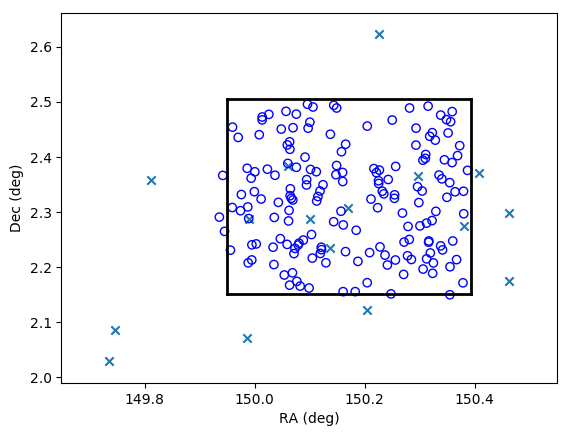

In [16]:

r_cat = photoz['R'].data
r_matched = r_cat[idx_uniq]

print(len(sep2d_uniq))

brightr = (r_matched < 23.) & (sep2d_uniq <0.3*u.arcsec)

# Compare again with CLAMATO sources as sanity check
clamato_specz_fil = '/Users/kheegan/lya/3d_recon/data/cl2017_redux/cl2017_valueadded_20170426_widez.txt'
clamato = ascii.read(clamato_specz_fil,format='fast_commented_header',header_start=-1)
#Make redshift and quality cuts
zcut = np.all(np.column_stack([(clamato['zspec'] >= zmin) ,
                            (clamato['zspec'] < zmax),
                             (clamato['Conf'] >= 3)]),axis=1)                            
clamato = clamato[zcut]

SC_cl = SkyCoord(ra = clamato['RA'].data*u.degree, dec=clamato['Dec'].data*u.degree)
SC_bright = SkyCoord(ra = ra_all[brightr]*u.degree, dec=dec_all[brightr]*u.degree)

cl_id = np.empty(np.sum(1 for i in brightr if i), dtype='int')
cl_id.fill(-99)

ind_cl, d2d_cl, junk = SC_bright.match_to_catalog_sky(SC_cl)
ind_bright, d2d_bright, junk2 = SC_cl.match_to_catalog_sky(SC_bright)
is_clamato = d2d_cl < 0.3*u.arcsec
is_bright = d2d_bright < 0.3*u.arcsec

clamato_id = clamato['ObjID'].data
cl_id[is_clamato] = clamato_id[ind_cl[is_clamato]]

print(" RA         Dec         z    Survey    mag   ID   ID_CLAMATO")
for ratmp, dectmp, ztmp, src, rtmp, idtmp, idcltmp in zip(ra_all[brightr], dec_all[brightr], z_all[brightr],
                                           source_all[brightr], r_matched[brightr], id_all[brightr], cl_id):
    print(ratmp, dectmp, ztmp, src, rtmp, idtmp, idcltmp) 

#fig, ax = plt.subplots()
#binwidth=0.1
#plt.hist(r_matched, bins=np.arange(22., 26., binwidth))
#plt.show()

fig, ax1 = plt.subplots()

#Set aspect ratio 
ax1.set_aspect('equal','datalim')

pl1 = ax1.scatter(ra_all[brightr], dec_all[brightr], marker='x' )
ax1.plot([ra0,ra1],[dec0,dec0], color='k',linestyle='-', linewidth=2)
ax1.plot([ra1,ra1],[dec0,dec1], color='k',linestyle='-', linewidth=2)
ax1.plot([ra1,ra0],[dec1,dec1], color='k',linestyle='-', linewidth=2)
ax1.plot([ra0,ra0],[dec1,dec0], color='k',linestyle='-', linewidth=2)

pl2 = ax1.scatter(clamato['RA'].data, clamato['Dec'].data, marker='o', edgecolors='b',facecolors='none')

#plt.legend(loc='upper right',scatterpoints=1)

ax1.set_ylabel('Dec (deg)')
ax1.set_xlabel('RA (deg)')

plt.show()

### Generate TOMO_FLAG and write to file

In [17]:
tomo_flag = np.all(np.column_stack([(ra_all >= ra0), (ra_all<=ra1),
                                  (dec_all >= dec0), (dec_all <= dec1),
                                  (z_all >= 2.05), (z_all <= 2.55)]), axis=1)
zero_lag = np.all(np.column_stack([(ra_all >= ra0), (ra_all<=ra1),
                                  (dec_all >= dec0), (dec_all <= dec1)]), axis=1)

tomo_flag = tomo_flag.astype(int)

galxcorr = Table([ra_all,dec_all,z_all,source_all,id_all, gmag_all, rmag_all, imag_all, tomo_flag],
                 names=('ra','dec','zspec','source','id', 'gmag','rmag', 'imag','tomo_flag'),
                dtype=('f8','f8','f4','U','i8','f4','f4','f4','i4'))
galxcorr['ra'].unit=u.degree
galxcorr['dec'].unit =u.degree

print('Saving %i galaxies' % len(galxcorr))
print('%i at zero lag' % np.sum(1 for i in zero_lag if i))
                                

ascii.write(galxcorr,'cat_galxcorr_cl2017_uniq_v2.dat',format='ipac', overwrite=True)

# Write a file that is in [x,y,z] coordinates relative to tomographic map
binfac = 2.  # To convert from Mpc/h to tomographic bins
z0 = 2.05  # redshift zero-point of tomographic map
dcomdisdz = 2998. * cosmo.inv_efunc(zmid)

x_all = (ra_all - ra0)/deg_per_hMpc * binfac
y_all = (dec_all - dec0)/deg_per_hMpc * binfac
zz_all = (z_all - z0)* dcomdisdz * binfac

get_tomo = np.where(tomo_flag == 1)

galtomo = Table([x_all[get_tomo], y_all[get_tomo], zz_all[get_tomo], source_all[get_tomo], id_all[get_tomo],
                rmag_all[get_tomo]], names=('x_map', 'y_map', 'z_map', 'source', 'id', 'rmag'),
               dtype=('f8', 'f8', 'f8', 'U', 'i8','f4'))

ascii.write(galtomo,'cat_tomoxyz_cl2017_uniq_v2.dat',format='ipac', overwrite=True)

catmd.close()

Saving 1422 galaxies
806 at zero lag


In [21]:
# Repeat but for overlap sample
tomo_flag = np.all(np.column_stack([(ra_ol >= ra0), (ra_ol<=ra1),
                                  (dec_ol >= dec0), (dec_ol <= dec1),
                                  (z_ol >= 2.05), (z_ol <= 2.55)]), axis=1)
zero_lag = np.all(np.column_stack([(ra_ol >= ra0), (ra_ol<=ra1),
                                  (dec_ol >= dec0), (dec_ol <= dec1)]), axis=1)

tomo_flag = tomo_flag.astype(int)

galxcorr = Table([ra_ol,dec_ol,z_ol,source_ol,id_ol, gmag_ol, rmag_ol, imag_ol, tomo_flag],
                 names=('ra','dec','zspec','source','id', 'gmag','rmag', 'imag','tomo_flag'),
                dtype=('f8','f8','f4','U','i8','f4','f4','f4','i4'))
galxcorr['ra'].unit=u.degree
galxcorr['dec'].unit =u.degree

print('Saving %i galaxies' % len(galxcorr))
print('%i at zero lag' % np.sum(1 for i in zero_lag if i))
                                

ascii.write(galxcorr,'cat_galxcorr_cl2017_nonuniq_v2.dat',format='ipac', overwrite=True)

# Write a file that is in [x,y,z] coordinates relative to tomographic map
binfac = 2.  # To convert from Mpc/h to tomographic bins
z0 = 2.05  # redshift zero-point of tomographic map
dcomdisdz = 2998. * cosmo.inv_efunc(zmid)

x_ol = (ra_ol - ra0)/deg_per_hMpc * binfac
y_ol = (dec_ol - dec0)/deg_per_hMpc * binfac
zz_ol = (z_ol - z0)* dcomdisdz * binfac

get_tomo = np.where(tomo_flag == 1)

galtomo = Table([x_ol[get_tomo], y_ol[get_tomo], zz_ol[get_tomo], source_ol[get_tomo], id_ol[get_tomo],
                rmag_ol[get_tomo]], names=('x_map', 'y_map', 'z_map', 'source', 'id', 'rmag'),
               dtype=('f8', 'f8', 'f8', 'U', 'i8','f4'))

ascii.write(galtomo,'cat_tomoxyz_cl2017_nonuniq_v2.dat',format='ipac', overwrite=True)


Saving 1681 galaxies
1060 at zero lag


In [22]:
print(np.shape((np.where((galxcorr['source']=='MOSDEF') & (galxcorr['tomo_flag'] ==1)))))

(1, 109)


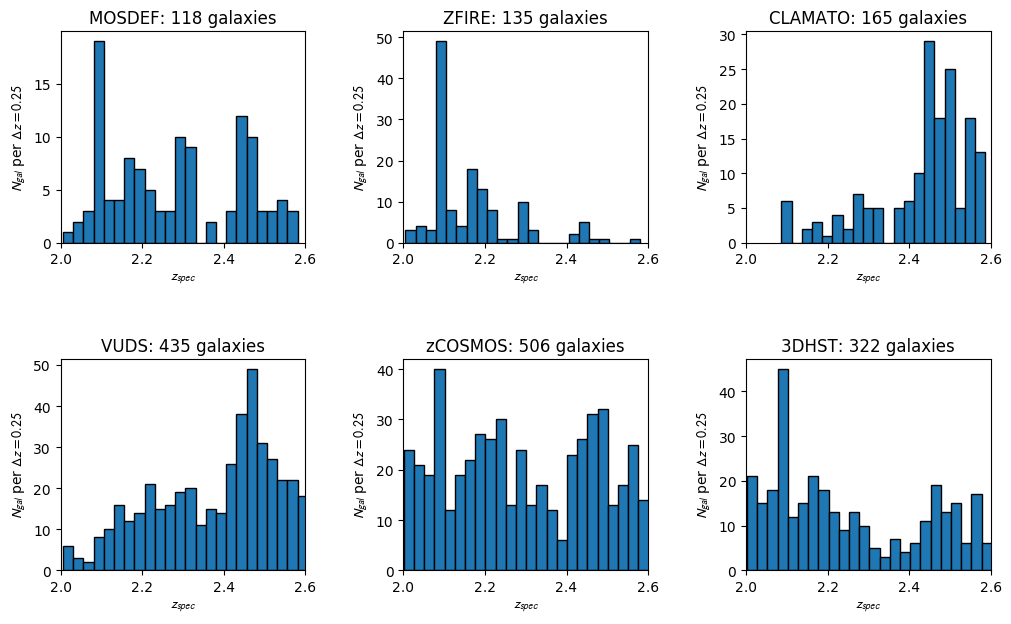

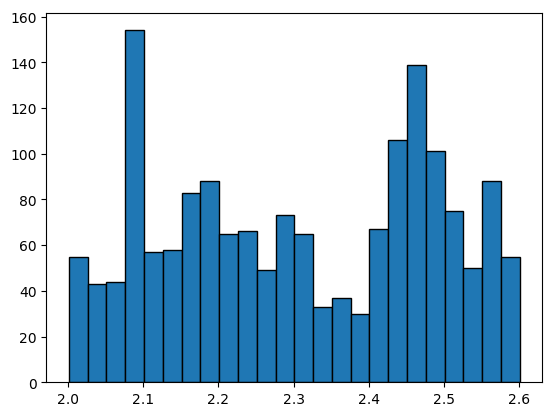

In [24]:
# Make subplots of all dNdz

fig, ((ax1, ax2, ax3),(ax4,ax5,ax6))= plt.subplots(2,3, figsize=(12,7))

zmin=2.0
zmax=2.6
binwidth=0.025

xlab_str = r'$z_{spec}$'
ylab_str = r'$N_{gal}$'+' per '+r'$\Delta z=0.25$'

getmosdef = source_ol == 'MOSDEF'
ax1.set_xlim(zmin,zmax)
ax1.set_xlabel(xlab_str)
ax1.set_ylabel(ylab_str)
ax1.set_title("MOSDEF: %i galaxies" % len(z_ol[getmosdef]))
ax1.hist(z_ol[getmosdef],bins=np.arange(min(z_ol[getmosdef]), 
                                        max(z_ol[getmosdef]) + binwidth, binwidth),ec='black')

getzfire = source_ol =='ZFIRE'
ax2.set_xlim(zmin,zmax)
ax2.set_xlabel(xlab_str)
ax2.set_ylabel(ylab_str)
ax2.set_title("ZFIRE: %i galaxies" % len(z_ol[getzfire]))
ax2.hist(z_ol[getzfire],bins=np.arange(min(z_ol[getzfire]), 
                                        max(z_ol[getzfire]) + binwidth, binwidth),ec='black')
getclamato = source_ol == 'CLAMATO'
ax3.set_xlim(zmin,zmax)
ax3.set_xlabel(xlab_str)
ax3.set_ylabel(ylab_str)
ax3.set_title("CLAMATO: %i galaxies" % len(z_ol[getclamato]))
ax3.hist(z_ol[getclamato],bins=np.arange(min(z_ol[getclamato]), max(z_ol[getclamato]) + binwidth, binwidth),
         ec='black')
    
getvuds = source_ol == 'VUDS'
ax4.set_xlim(zmin,zmax)
ax4.set_xlabel(xlab_str)
ax4.set_ylabel(ylab_str)
ax4.set_title("VUDS: %i galaxies" % len(z_ol[getvuds]))
ax4.hist(z_ol[getvuds],bins=np.arange(min(z_ol[getvuds]), max(z_ol[getvuds]) + binwidth, binwidth),
         ec='black')

getzcosmos = source_ol =='zDeep'
ax5.set_xlim(zmin,zmax)
ax5.set_xlabel(xlab_str)
ax5.set_ylabel(ylab_str)
ax5.set_title("zCOSMOS: %i galaxies" % len(z_ol[getzcosmos]))
ax5.hist(z_ol[getzcosmos],bins=np.arange(min(z_ol[getzcosmos]), max(z_ol[getzcosmos]) + binwidth, binwidth),
         ec='black')

get3d = source_ol =='3DHST'
ax6.set_xlim(zmin,zmax)
ax6.set_xlabel(xlab_str)
ax6.set_ylabel(ylab_str)
ax6.set_title("3DHST: %i galaxies" % len(z_ol[get3d]))
ax6.hist(z_ol[get3d],bins=np.arange(min(z_ol[get3d]), max(z_ol[get3d]) + binwidth, binwidth),
         ec='black')

fig.subplots_adjust(hspace=0.55)
fig.subplots_adjust(wspace=0.4)

plt.show()

fig, ax = plt.subplots()
binwidth=0.025
plt.hist(z_ol,bins=np.arange(min(z_ol), max(z_ol) + binwidth, binwidth),ec='black')
plt.show()